## Regression Discontinuity

In this brief notebook, I will go through how to implement a simple regression discontinuity design, using the functions in the rdd package.

In [5]:
# Import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdd import rdd

## Generate Data

In [6]:
np.random.seed(42)
N = 10000
x = np.random.normal(1, 1, N)
epsilon = np.random.normal(0, 1, N)
threshold = 1
treatment = np.where(x >= threshold, 1, 0)
w1 = np.random.normal(0, 1, N)
w2 = np.random.normal(0, 4, N)
y = .5 * treatment + 2 * x - .2 * w1 + 1 + epsilon

data = pd.DataFrame({'y':y, 'x': x, 'w1':w1, 'w2':w2})
data.head()

,y,x,w1,w2
0,3.745276,1.496714,0.348286,-7.922288
1,2.361307,0.861736,0.283324,-4.219943
2,4.385300,1.647689,-0.936520,-2.348114
3,6.540561,2.523030,0.579584,0.598676
4,4.026888,0.765847,-1.490083,4.096649


## Restrict Data

When running our RDD, we first want to choose a bandwidth that we will use to restrict our dataset to only analyze observations that are very close to the threshold. We can pick whatever bandwidth we like, or we can select the optimal bandwidth.

We do this by giving optimal_bandwidth() our outcome variable, the running variable, and the threshold in the running variable.

In [7]:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)

Optimal bandwidth: 0.7448859965965805


Now let's restrict the dataset to be only observations within this bandwidth of the threshold.

(Note: truncated_data() can also call optimal_bandwidth(), which saves you a step)

In [8]:
data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=threshold)

In [9]:
data_rdd.head()

,y,x,w1,w2
0,3.745276,1.496714,0.348286,-7.922288
1,2.361307,0.861736,0.283324,-4.219943
2,4.385300,1.647689,-0.936520,-2.348114
4,4.026888,0.765847,-1.490083,4.096649
5,1.891521,0.765863,-0.654184,2.776544


## Check for the Presence of a Discontinuity

Before we move to estimation, let's see if graphically it even looks like there is a discontinuous change in the outcome at the threshold. We use a regular scatter plot.

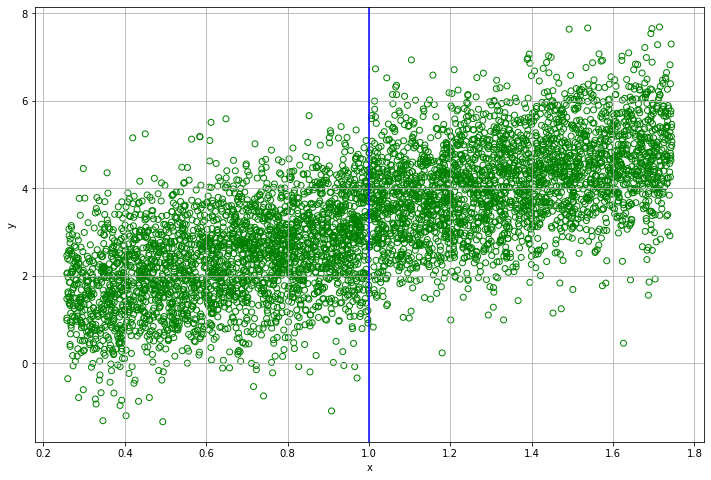

In [23]:
plt.figure(figsize=(12, 8))
plt.scatter(data_rdd['x'], data_rdd['y'], facecolors='none', edgecolors='g')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(x=threshold, color='b')
plt.grid(True)
plt.show()
plt.close()

As you can see, it's really hard to tell what's going on at the threshold - it's far to noisy. So what we'll do is put the data into bins based on the running variable, get the average value of the outcome variable in each bin, then plot the result. This will allow us to parse through the noise.

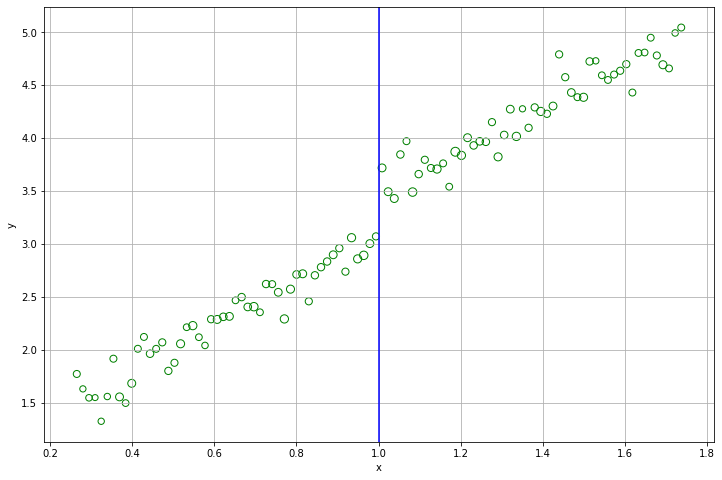

In [24]:
data_binned = rdd.bin_data(data_rdd, 'y', 'x', 100)

plt.figure(figsize=(12, 8))
plt.scatter(data_binned['x'], data_binned['y'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='g')
plt.axvline(x=threshold, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()
plt.close()

That's better - it's much easier to see discontinuity now. When we run our estimation, it should be easy to detect this. If we didn't see any change in the plot, but did find a treatment effect in our estimation (or vice versa), we might be worried.

Why do we weight by the number of observations in each bin? The number of observations is not equal across bins, and this can help inform the results we get from our estimation in the next step.

## Estimation

Now the fun part. All we have to do is estimate a simple linear regression of the outcome variable on a dummy variable for whether the observations lies to the right or left of the variable (which we'll call TREATED), and the running variable. We could do this ourselves, but we can also run rdd(). The output will be a Statsmodels linear regression object, which we can then fit and display results for.

(Note: While weighted least squares is used, the default weights are 1, resulting in OLS by default.)

In [12]:
model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold)
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.508
Model:                            WLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     2811.
Date:                Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:42:38   Log-Likelihood:                -7794.0
No. Observations:                5442   AIC:                         1.559e+04
Df Residuals:                    5439   BIC:                         1.561e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

It looks pretty good! We're getting a treatment effect that is pretty close to the actual treatment effect (even though we've omitted a variable).

We can also add controls, change the covariance structure, specify our own equation, or run weighted least squares.

In [13]:
model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold, controls=['w1', 'w2'])
print(model.fit(cov_type='hc1').summary())

Estimation Equation:	 y ~ TREATED + x + w1 + w2
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.523
Model:                            WLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     1520.
Date:                Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:45:00   Log-Likelihood:                -7709.9
No. Observations:                5442   AIC:                         1.543e+04
Df Residuals:                    5437   BIC:                         1.546e+04
Df Model:                           4                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Inte

In [14]:
model = rdd.rdd(data_rdd, 'x', cut=threshold, equation='y ~ TREATED + x + w1*w2')
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x + w1*w2
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.523
Model:                            WLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     1194.
Date:                Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:45:40   Log-Likelihood:                -7709.6
No. Observations:                5442   AIC:                         1.543e+04
Df Residuals:                    5436   BIC:                         1.547e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

## Validation: Placebo Tests

How can we check to see if our results are robust? One method is to repeat the analysis, using a fake threshold. This placebo test should result in a null treatment effect -- since the threshold is fake, nothing is inherently different for observations on either side. If we do still see a statistially significant coefficient on TREATED, that may be cause for alarm.

Let's put a fake threshold at 0, and test for the causal effect there.

In [19]:
data_placebo = rdd.truncated_data(data, 'x', yname='y', cut=0)

In [20]:
model = rdd.rdd(data_placebo, 'x', 'y', cut=0, controls=['w1'])
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x + w1
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.375
Model:                            WLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     660.8
Date:                Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:48:28   Log-Likelihood:                -4633.4
No. Observations:                3310   AIC:                             9275.
Df Residuals:                    3306   BIC:                             9299.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept

There's no statistical effect! Excellent.